# Analysis of the Distribution and Variation of Temperatures in the Contiguous 48 States
Jessica Embury

# CDC DATA PROCESSING
Data downloaded from CDC Wonder: https://wonder.cdc.gov/controller/datarequest/

In [ ]:
#import modules
import pandas as pd
import geopandas as gpd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import geoplot

from shapely.geometry import Polygon
from shapely.geometry import Point

In [2]:
#file paths

#CDC data on health deaths
cdc_df = pd.read_csv('input/heat_deaths.csv')

#US counties shapefile
county_gdf = gpd.read_file('input/shapefiles/tl_2017_us_county.shp')

#file paths to export shapefiles containing merged data
shapefile_out_path = 'output/shapefiles/heatdeath_county.shp'

In [3]:
#Format cdc heat death dataframe prior to merge with county shapefile geodf

#rename columns
cdc_df = cdc_df.rename(columns = {'County Code':'GEOID','Cause of death Code':'CAUSE_DEATH','Crude Rate':'RELIABLE'})

#subset data
cdc_df = cdc_df[['County','GEOID','CAUSE_DEATH','Deaths','Population','CDR','RELIABLE']]
cdc_df.head()

,County,GEOID,CAUSE_DEATH,Deaths,Population,CDR,RELIABLE
0,"Apache County, AZ",4001,X30,12,1264681,0.9,0.9 (Unreliable)
1,"Coconino County, AZ",4005,X30,13,2329635,0.6,0.6 (Unreliable)
2,"La Paz County, AZ",4012,X30,18,362989,5.0,5.0 (Unreliable)
3,"Maricopa County, AZ",4013,X30,529,65854171,0.8,0.8
4,"Mohave County, AZ",4015,X30,47,3390447,1.4,1.4


In [4]:
#Simplify reliability data from CDR with notation to Yes/No value

for i,row in cdc_df.iterrows():
    if 'Unreliable' in cdc_df['RELIABLE'].loc[i]:
        cdc_df['RELIABLE'].loc[i] = 'No'
    else:
        cdc_df['RELIABLE'].loc[i] = 'Yes'

C:\Users\jesse\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
#Add a leading zero to GEOID column if GEOID has 4 digits
#Formatting to match cdc_df GEOID column with the county_gdf GEOID column

for i,row in cdc_df.iterrows():
    temp = str(cdc_df['GEOID'].loc[i])
    if (len(temp) == 4):
        temp = '0'+temp
    #print(temp)
    cdc_df['GEOID'].loc[i] = temp

In [6]:
cdc_df.head()

,County,GEOID,CAUSE_DEATH,Deaths,Population,CDR,RELIABLE
0,"Apache County, AZ",04001,X30,12,1264681,0.9,No
1,"Coconino County, AZ",04005,X30,13,2329635,0.6,No
2,"La Paz County, AZ",04012,X30,18,362989,5.0,No
3,"Maricopa County, AZ",04013,X30,529,65854171,0.8,Yes
4,"Mohave County, AZ",04015,X30,47,3390447,1.4,Yes


In [7]:
#Prepare county gdf for merge with cdc heat death dataframe

#very shapefile crs
print(county_gdf.crs)

#subset data (eliminate unneeded info)
county_gdf = county_gdf[['STATEFP','COUNTYFP','GEOID','NAME','geometry']]
county_gdf.head()

{'init': 'epsg:4269'}


,STATEFP,COUNTYFP,GEOID,NAME,geometry
0,31,039,31039,Cuming,"POLYGON ((-97.019516 42.004097, -97.019519 42...."
1,53,069,53069,Wahkiakum,"POLYGON ((-123.436394 46.238197, -123.447592 4..."
2,35,011,35011,De Baca,"POLYGON ((-104.567387 33.997566, -104.567717 3..."
3,31,109,31109,Lancaster,"POLYGON ((-96.91059899999999 40.958407, -96.91..."
4,31,129,31129,Nuckolls,"POLYGON ((-98.27366699999999 40.089399, -98.27..."


In [8]:
#merge cdc_df and county_gdf
county_gdf2=pd.merge(county_gdf,cdc_df,how='outer', on='GEOID')

county_gdf2.head()

,STATEFP,COUNTYFP,GEOID,NAME,geometry,County,CAUSE_DEATH,Deaths,Population,CDR,RELIABLE
0,31,039,31039,Cuming,"POLYGON ((-97.019516 42.004097, -97.019519 42....",NaN,NaN,NaN,NaN,NaN,NaN
1,53,069,53069,Wahkiakum,"POLYGON ((-123.436394 46.238197, -123.447592 4...",NaN,NaN,NaN,NaN,NaN,NaN
2,35,011,35011,De Baca,"POLYGON ((-104.567387 33.997566, -104.567717 3...",NaN,NaN,NaN,NaN,NaN,NaN
3,31,109,31109,Lancaster,"POLYGON ((-96.91059899999999 40.958407, -96.91...",NaN,NaN,NaN,NaN,NaN,NaN
4,31,129,31129,Nuckolls,"POLYGON ((-98.27366699999999 40.089399, -98.27...",NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Verify merge of cdc and spatial data
county_gdf2.query('NAME == "La Paz"')

,STATEFP,COUNTYFP,GEOID,NAME,geometry,County,CAUSE_DEATH,Deaths,Population,CDR,RELIABLE
2389,04,012,04012,La Paz,"POLYGON ((-114.731222 33.304039, -114.729904 3...","La Paz County, AZ",X30,18.0,362989.0,5.0,No


In [10]:
#Replace NaN values with 0 for counties with zero (or fewer than 10) heat related deaths for columns 'Deaths' and 'CDR'

county_gdf2['Deaths'] = county_gdf2['Deaths'].fillna(0)
county_gdf2['CDR'] = county_gdf2['CDR'].fillna(0)

### KEEP ONLY DATA FOR THE 48 CONTIGUOUS STATES:

In [12]:
#create bounding box for contiguous 48 states
geometry = [Polygon([[-128,22],[-128,52],[-65,52],[-65,22]])]

#use same crs as county_gdf
crs = {'init':'epsg:4269'}

#create bounding box geodataframe
bbox_gdf = gpd.GeoDataFrame(crs = crs, geometry = geometry)
bbox_gdf

,geometry
0,"POLYGON ((-128 22, -128 52, -65 52, -65 22, -1..."


In [13]:
#keep only counties that are within bounding box
county_gdf2 = gpd.sjoin(county_gdf2, bbox_gdf, op='within')

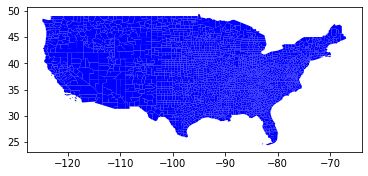

In [14]:
#plot county_gdf
fig, ax = plt.subplots()
county_gdf2.plot(ax=ax, color='blue')
plt.show()

In [15]:
#delete index column from spatial join with bounding box
del county_gdf2['index_right']

#inspect gdf prior to exportation as shapefile
county_gdf2.head()

,STATEFP,COUNTYFP,GEOID,NAME,geometry,County,CAUSE_DEATH,Deaths,Population,CDR,RELIABLE
0,31,039,31039,Cuming,"POLYGON ((-97.019516 42.004097, -97.019519 42....",NaN,NaN,0.0,NaN,0.0,NaN
1,53,069,53069,Wahkiakum,"POLYGON ((-123.436394 46.238197, -123.447592 4...",NaN,NaN,0.0,NaN,0.0,NaN
2,35,011,35011,De Baca,"POLYGON ((-104.567387 33.997566, -104.567717 3...",NaN,NaN,0.0,NaN,0.0,NaN
3,31,109,31109,Lancaster,"POLYGON ((-96.91059899999999 40.958407, -96.91...",NaN,NaN,0.0,NaN,0.0,NaN
4,31,129,31129,Nuckolls,"POLYGON ((-98.27366699999999 40.089399, -98.27...",NaN,NaN,0.0,NaN,0.0,NaN


### EXPORT SHAPEFILES

In [16]:
#exports county_gdf as an ESRI shapefile

county_gdf2.to_file(driver = "ESRI Shapefile", filename = shapefile_out_path)

In [17]:
#create county shapefile of ONLY counties with reported heat deaths

#query counties with deaths
county_gdf3 = county_gdf2.query('Deaths != "0.0"').reset_index()

county_gdf3.head()

,index,STATEFP,COUNTYFP,GEOID,NAME,geometry,County,CAUSE_DEATH,Deaths,Population,CDR,RELIABLE
0,78,12,127,12127,Volusia,"POLYGON ((-81.502797 29.106274, -81.502844 29....","Volusia County, FL",X30,15.0,8749159.0,0.2,No
1,151,32,003,32003,Clark,"POLYGON ((-115.896925 36.842085, -115.891591 3...","Clark County, NV",X30,192.0,32448616.0,0.6,Yes
2,183,24,510,24510,Baltimore,"POLYGON ((-76.71150899999999 39.366215, -76.71...","Baltimore city, MD",X30,48.0,11287141.0,0.4,Yes
3,200,48,027,48027,Bell,"POLYGON ((-97.815854 31.11621, -97.81492799999...","Bell County, TX",X30,13.0,5183995.0,0.3,No
4,218,48,215,48215,Hidalgo,"POLYGON ((-98.38667799999999 26.157968, -98.38...","Hidalgo County, TX",X30,12.0,12903062.0,0.1,No


In [18]:
#delete old index column
del county_gdf3['index']

#inspect gdf prior to exportation of shapefile
county_gdf3.head()

,STATEFP,COUNTYFP,GEOID,NAME,geometry,County,CAUSE_DEATH,Deaths,Population,CDR,RELIABLE
0,12,127,12127,Volusia,"POLYGON ((-81.502797 29.106274, -81.502844 29....","Volusia County, FL",X30,15.0,8749159.0,0.2,No
1,32,003,32003,Clark,"POLYGON ((-115.896925 36.842085, -115.891591 3...","Clark County, NV",X30,192.0,32448616.0,0.6,Yes
2,24,510,24510,Baltimore,"POLYGON ((-76.71150899999999 39.366215, -76.71...","Baltimore city, MD",X30,48.0,11287141.0,0.4,Yes
3,48,027,48027,Bell,"POLYGON ((-97.815854 31.11621, -97.81492799999...","Bell County, TX",X30,13.0,5183995.0,0.3,No
4,48,215,48215,Hidalgo,"POLYGON ((-98.38667799999999 26.157968, -98.38...","Hidalgo County, TX",X30,12.0,12903062.0,0.1,No


In [21]:
#county centroids
centroid = county_gdf3.centroid
centroid.head()

0    POINT (-81.14857482792611 29.06344966056411)
1    POINT (-115.0135616988809 36.21519810075496)
2    POINT (-76.61064742416842 39.30098016084477)
3     POINT (-97.47820239630089 31.0376717139223)
4     POINT (-98.18107050601375 26.3967205709691)
dtype: object

In [23]:
county_gdf3['geometry'] = centroid
county_gdf3.head()

,STATEFP,COUNTYFP,GEOID,NAME,geometry,County,CAUSE_DEATH,Deaths,Population,CDR,RELIABLE
0,12,127,12127,Volusia,POINT (-81.14857482792611 29.06344966056411),"Volusia County, FL",X30,15.0,8749159.0,0.2,No
1,32,003,32003,Clark,POINT (-115.0135616988809 36.21519810075496),"Clark County, NV",X30,192.0,32448616.0,0.6,Yes
2,24,510,24510,Baltimore,POINT (-76.61064742416842 39.30098016084477),"Baltimore city, MD",X30,48.0,11287141.0,0.4,Yes
3,48,027,48027,Bell,POINT (-97.47820239630089 31.0376717139223),"Bell County, TX",X30,13.0,5183995.0,0.3,No
4,48,215,48215,Hidalgo,POINT (-98.18107050601375 26.3967205709691),"Hidalgo County, TX",X30,12.0,12903062.0,0.1,No


In [24]:
print(len(county_gdf3))

112


In [25]:
#exports county_gdf as an ESRI shapefile

centroid_path = 'output/shapefiles/death_centroids.shp'
county_gdf3.to_file(driver = "ESRI Shapefile", filename = centroid_path)